<a href="https://colab.research.google.com/github/Mmabatho/AI-For-Software-Engineeering-Week-3/blob/brian/Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Creating path

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
bittlingmayer_amazonreviews_path = kagglehub.dataset_download('bittlingmayer/amazonreviews')

print('Data source import complete.')


Data source import complete.


In [3]:
# Checking the path
bittlingmayer_amazonreviews_path

'/kaggle/input/amazonreviews'

### Loading necessary libraries

In [4]:
import spacy
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
import bz2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
# Show files in the path
print(os.listdir(bittlingmayer_amazonreviews_path))

['test.ft.txt.bz2', 'train.ft.txt.bz2']


### Loading file from the Drive

In [6]:
train_path = '/content/drive/MyDrive/amazonreviews_data/train.ft.txt.bz2'
test_path = '/content/drive/MyDrive/amazonreviews_data/test.ft.txt.bz2'

def load_data(file_path):
    texts = []
    labels = []
    with bz2.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            # if the format is __label__X followed by the review text
            label = int(line[9]) - 1  # Adjust label to be 0 or 1 (for __label__1 and __label__2)
            text = line[11:].strip()
            texts.append(text)
            labels.append(label)
    return pd.DataFrame({'text': texts, 'label': labels})

In [7]:
train_df = load_data(train_path)
test_df = load_data(test_path)

print("Train DataFrame head:")
print(train_df.head())
print("\nTest DataFrame head:")
print(test_df.head())

Train DataFrame head:
                                                text  label
0  Stuning even for the non-gamer: This sound tra...      1
1  The best soundtrack ever to anything.: I'm rea...      1
2  Amazing!: This soundtrack is my favorite music...      1
3  Excellent Soundtrack: I truly like this soundt...      1
4  Remember, Pull Your Jaw Off The Floor After He...      1

Test DataFrame head:
                                                text  label
0  Great CD: My lovely Pat has one of the GREAT v...      1
1  One of the best game music soundtracks - for a...      1
2  Batteries died within a year ...: I bought thi...      0
3  works fine, but Maha Energy is better: Check o...      1
4  Great for the non-audiophile: Reviewed quite a...      1


In [8]:
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase, removing punctuation and digits,
    splitting into words, removing stop words, and applying lemmatization.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """
    # Convert the text to lowercase
    text = text.lower()

    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text).strip()   # Remove punctuation
    text = re.sub(r'\d+', '', text).strip()        # Remove digits

    # Split the text into words
    words = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))

    # Remove both general stop words and false-meaning words
    words = [word for word in words if word not in stop_words]

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [9]:
# Cleaning the text by applying the preprocess_text function to each review in the 'review' column
train_df['text'] = train_df['text'].apply(preprocess_text)  # Clean the text in the train DataFrame
train_df.head()

,text,label
0,stuning even nongamer sound track beautiful pa...,1
1,best soundtrack ever anything im reading lot r...,1
2,amazing soundtrack favorite music time hand in...,1
3,excellent soundtrack truly like soundtrack enj...,1
4,remember pull jaw floor hearing youve played g...,1


In [10]:
test_df['text'] = test_df['text'].apply(preprocess_text)  # Clean the text in the test DataFrame
test_df.head()

,text,label
0,great cd lovely pat one great voice generation...,1
1,one best game music soundtrack game didnt real...,1
2,battery died within year bought charger jul wo...,0
3,work fine maha energy better check maha energy...,1
4,great nonaudiophile reviewed quite bit combo p...,1


### Named Entity Recognition (NER)

In [13]:
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    products = [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT']
    brands = [ent.text for ent in doc.ents if ent.label_ == 'ORG' or ent.label_ == 'PRODUCT'] # Using ORG and PRODUCT for potential brand mentions
    return products, brands

In [15]:
# Sample a subset of the DataFrame
sample_size = 100000
if len(train_df) > sample_size:
  sampled_train_df = train_df.sample(n=sample_size, random_state=42).copy() # Use .copy() to avoid SettingWithCopyWarning
else:
  sampled_train_df = train_df.copy()

# Apply entity extraction to the sampled data
sampled_train_df['products'], sampled_train_df['brands'] = zip(*sampled_train_df['text'].apply(extract_entities))

# Create the list of product and brand combinations
product_brand_list = []
for index, row in sampled_train_df.iterrows():
  for product in row['products']:
    for brand in row['brands']:
      product_brand_list.append({'product': product, 'brand': brand})

In [16]:
product_brand_df = pd.DataFrame(product_brand_list)

print(product_brand_df.head())

    product     brand
0    hondas    hondas
1  zucchero  zucchero
2  muy buen        un
3  muy buen  muy buen
4      cole      cole


In [17]:
product_brand_df.shape

(873, 2)

In [19]:
product_brand_df['product'].value_counts(normalize=True, ascending=False).head(10)

,proportion
product,
cole,0.130584
atlantis,0.084765
google,0.042383
mosaic,0.025200
jimmy,0.022910
cherokee,0.020619
viejo consumido,0.019473
viejo de años,0.019473
martin,0.017182


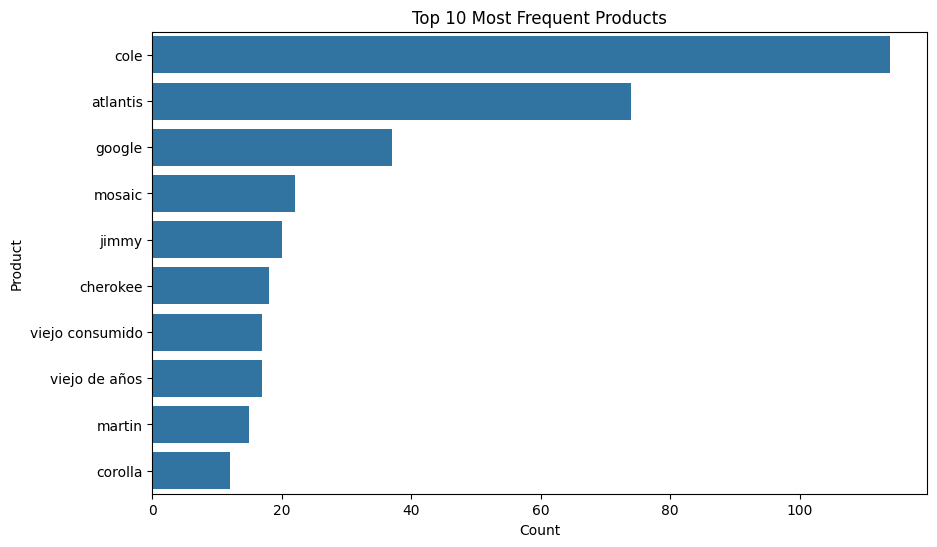

In [20]:
# Visualize the top 10 most frequent products
plt.figure(figsize=(10, 6))
sns.countplot(y='product', data=product_brand_df, order=product_brand_df['product'].value_counts().index[:10])
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Count')
plt.ylabel('Product')
plt.show();